In [33]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms,utils, models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict




In [39]:


data_dir = 'crowdai_plant_disease'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'


data_transforms_train = transforms.Compose([#transforms.Resize(256),  #transforms.RandomRotation([-30,30]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


data_transforms_test_eval = transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


trainset = datasets.ImageFolder(train_dir, transform=data_transforms_train)
testset = datasets.ImageFolder(test_dir, transform=data_transforms_test_eval)
#trainset = datasets.DatasetFolder(train_dir, transform=data_transforms_train)
#testset = datasets.DatasetFolder(test_dir, transform=data_transforms_test_eval)
                                                
                                                
# TODO: Using the image datasets and the trainforms, define the dataloaders

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)                                                


torch.Size([64, 3, 224, 224])
torch.Size([64])


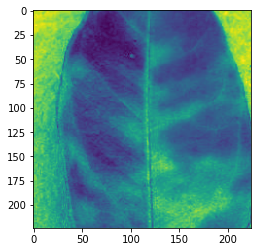

In [57]:
image,label=next(iter(train_loader))
print(image.size())
print(label.size())
plt.imshow(image[0][0,:])

In [58]:
model = models.resnet152(pretrained=True)
input_size = 2048
hidden_sizes = [1024,512,256]
output_size = 38

for param in model.parameters():
    param.requires_grad = False


classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                          ('relu1', nn.ReLU()),
                          ('dropout1',nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                          ('relu2', nn.ReLU()),
                          ('dropout2',nn.Dropout(p=0.2)),
                          ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                          ('relu3', nn.ReLU()),
                          ('dropout3',nn.Dropout(p=0.1)),
                          ('fc4', nn.Linear(hidden_sizes[2], output_size))
                          #('output', nn.LogSoftmax(dim=1))
                          ]))
        
model.fc = classifier 

In [59]:
epochs=10
criterion=torch.nn.CrossEntropyLoss()  #if increase the lr to 0.1, it kicks to local min and stays
optimizer=torch.optim.Adam(model.fc.parameters(),lr=0.001)  #had to change from SGD to Adam but later noy much difference
lr_scheduler_=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lr_scheduler_=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [60]:
def train_function(train_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0
    
    model.to(device)

    for epoch in range(epochs):
        model.train()

        for step,(inputs,labels) in enumerate(train_loader):
            
            optimizer.zero_grad()
            
            inputs=inputs.to(device)
            labels=labels.to(device)

            #input.resize_(input.size()[0], 784)   take to forward
            y_pred=model.forward(inputs)   #this is 64 (bacth_size)*10
            
            if(count==0): print(y_pred.size(),labels.size())
            loss=criterion(y_pred,labels)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count=count+1
            #y_pred_round=torch.round(y_pred)
            count_batch=count_batch+(labels.size()[0])
            _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            acc=(labels==y_pred_).sum().item()    #/label.size()[0]
            sum_acc=sum_acc+acc
            #print(count)
            if(step%40==0): 
                print('epoch',epoch+1,'/',epochs,'train running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))
                print('-----')
                test_function(test_loader)
                print('---------------------')
                model.train()
            
        check_loss=(loss_running/count_batch)
        lr_scheduler_.step(check_loss)



In [61]:
def test_function(test_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0
    
    model.eval()
    
    with torch.no_grad():
        
        for _,(inputs,labels) in enumerate(test_loader):
            
            
            inputs=inputs.to(device)
            labels=labels.to(device)

            #input.resize_(input.size()[0], 784)   take to forward
            y_pred=model.forward(inputs)   #this is 64 (bacth_size)*10

            #if(count==0): print(y_pred.size(),label.size())
            loss=criterion(y_pred,labels)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            count=count+1
            #print('count_test',count)
            count_batch=count_batch+(label.size()[0])
            _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            acc=(labels==y_pred_).sum().item()    #/label.size()[0]
            sum_acc=sum_acc+acc
        print('test running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))




#test_function(test_loader)   # w/o convnet :result show over fitting on train 64%, but overall 50% on test is not too bad wihtout convnet
#w/ convnet just after 5 epoch training the test got to 63% (50% train)
#after 10 epoch test get to 66% pretty good without big networks

#CiFAR10 with inception better in training improve to 64% but not much better for test at 64% (may be need derop out and more fc)

#after more fc on top of inception got to 70% test, 

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_function(train_loader)

cuda
torch.Size([64, 38]) torch.Size([64])
epoch 1 / 10 train running_loss: 0.056911859661340714 Accuracy 1.5625
-----
test running_loss: 0.055761809376153076 Accuracy 10.890151515151516
---------------------
epoch 1 / 10 train running_loss: 0.04702206991794633 Accuracy 22.599085365853657
-----
test running_loss: 0.035563827181855835 Accuracy 39.72537878787879
---------------------
epoch 1 / 10 train running_loss: 0.03996204948167742 Accuracy 32.44598765432099
-----
test running_loss: 0.02493243393572894 Accuracy 53.55113636363637
---------------------
epoch 1 / 10 train running_loss: 0.03481332162656814 Accuracy 39.127066115702476
-----
test running_loss: 0.01762719328204791 Accuracy 64.58333333333333
---------------------
epoch 1 / 10 train running_loss: 0.031158838791321523 Accuracy 44.61374223602485
-----
test running_loss: 0.014016710870871038 Accuracy 71.73295454545455
---------------------
epoch 1 / 10 train running_loss: 0.028522472078008437 Accuracy 48.6396144278607
-----
test

epoch 6 / 10 train running_loss: 0.010927148810522522 Accuracy 78.8393337834027
-----
test running_loss: 0.0031734257583703957 Accuracy 92.8030303030303
---------------------
epoch 7 / 10 train running_loss: 0.010858660033633907 Accuracy 78.96405564059005
-----
test running_loss: 0.003047033784572374 Accuracy 93.08712121212122
---------------------
epoch 7 / 10 train running_loss: 0.010768841247977229 Accuracy 79.12090626183459
-----
test running_loss: 0.004740676835574435 Accuracy 90.38825757575758
---------------------
epoch 7 / 10 train running_loss: 0.010690854154044803 Accuracy 79.28256978375502
-----
test running_loss: 0.0034187078356009088 Accuracy 92.28219696969697
---------------------
epoch 7 / 10 train running_loss: 0.010610549825537368 Accuracy 79.43690455500608
-----
test running_loss: 0.004512522852923156 Accuracy 90.76704545454545
---------------------
epoch 7 / 10 train running_loss: 0.010520824205174242 Accuracy 79.59596116023725
-----
test running_loss: 0.003407983059

In [63]:
# TODO: Save the checkpoint 

checkpoint = {'input_size': 2048,
              'output_size': 38,
              'hidden_layers': [1024,512,256],
              'model_name':'resnet152',
              'optimizer_name':'Adam',
              'model_base':model,
              'model_classifier':model.fc,
              'optimizer':optimizer,
              'model_state_dict': model.state_dict(),'optimizer_state_dict':optimizer.state_dict,
              'optimizer_state_dict_':optimizer.state_dict(),'criterion_loss_function':criterion,
              'epochs':10,'printing_batch':40,'device':'cuda',
              'class_to_label': trainset.class_to_idx}   

# "state_dic" keep the weights of the model only for a specific structure
# 'class_to_label' keep conversion to 
# 'label_to_name' use json file to get the name of label (by using class_to_idx)
# 'optimizer_state_dict' general shape of optimizer
# 'optimizer_state_dict()' content of optimizer
# 'epochs' number of epochs run
# 'printing_batch' how often print
torch.save(checkpoint, 'checkpoint_adam_resnet152_10epoch_opti_name_plant_village.pth')



In [20]:
import torch
print(torch.__version__)

0.4.0
